In [3]:
from imports import *
from data import *
from arch import *
model = return_token_model(CORE_MODEL, len(labels), preferred_cuda_test);
#model.load_state_dict(torch.load(CHECKPOINT_PATH + ROOT_NAME + '3_17000.pt')["model_state_dict"]);
#model.load_state_dict(torch.load("/mnt/SSD2/pholur/CTs/checkpoints/Day_0928_Insider_Outsider_79_54480.pt")["model_state_dict"]);
model.load_state_dict(torch.load("/mnt/SSD2/pholur/CTs/checkpoints/Day_0928_Insider_Outsider_20_14301.pt")["model_state_dict"]);
model.eval();

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

In [4]:
from shared_train_and_test_functions import tokenization
import spacy
from spacy import displacy
import nltk
nlp = spacy.load('en_core_web_sm')
# ONLY WORKS FOR SINGLE POST TESTING

In [16]:
def return_insiders_and_outsiders(text, option_display=False):
    doc = nlp(text)
    add_np_text = []
    spans = []
    for npy in doc.noun_chunks:
        add_np_text.append(npy.text)
        spans.append((npy.start_char, npy.end_char))

    test_encodings, tokens = tokenization([text], True)
    offset_mappings = test_encodings.offset_mapping[0]

    input_ids = torch.tensor(test_encodings['input_ids']).to(preferred_cuda_test)
    attention_mask = torch.tensor(test_encodings['attention_mask']).to(preferred_cuda_test)
    outputs = model(input_ids, attention_mask=attention_mask) # try this: labels = torch.tensor([0]*len(input_ids)).to(preferred_cuda_test))
    predictions = outputs[0].detach().cpu().numpy()
    single_prediction_post = predictions[0]
    predictions_argmax = np.argmax(single_prediction_post, axis=1)
    # print(predictions_argmax)
    # print(outputs)
    ents = []
    total_true = {}

    for i in range(len(spans)):
        total_true[i] = False
    
    for j in range(len(spans)):
        
        choice = "no"
        for i,index in enumerate(predictions_argmax):
            current_token_mapping = offset_mappings[i]
 
            if current_token_mapping[0] >= spans[j][0] and current_token_mapping[1] <= spans[j][1]: # if the token is in the span of a chunk
                if index == 2:
                    choice = "yes"
                else:
                    choice = "no"

        if choice == "no":
            ents.append({"start": spans[j][0], "end": spans[j][1], "label": "INSIDER"})
        else:
            ents.append({"start": spans[j][0], "end": spans[j][1], "label": "OUTSIDER"})

    # deduplicate list of dictionaries
    ents = [dict(t) for t in {tuple(d.items()) for d in ents}]
    # sort list of dictionaries by start index
    ents = sorted(ents, key=lambda x: x['start'])
    #print(ents)
    options = {"colors": {"INSIDER":"#88C6F1", "OUTSIDER":"#FF82AB"}}
    ex = [{"text": text, "ents": ents}]
    if option_display == True:
        displacy.render(ex, style="ent", manual=True, options=options)
        return None
    else:
        dictionary_map = {}
        for ent in ents:
            dictionary_map[text[ent['start']:ent['end']]] = ent['label']
        return dictionary_map

In [13]:
#posts = ["I think that #BigTech will kill me with vaccines. People like Bill Gates are doing it for the money. My friend, Sarah, who is a doctor, told me not to get the vaccine, because it causes cancer."]
posts = ["5g causes cancer", "5g is good for the economy.", "We should burn cell phone towers.", "We should build cell phone towers.", "Radio waves are as potent as vaccines.", "Vaccines are not harmful.", "Microchips are telling the government where we are 24/7.", "Vaccines contain microchips.", \
    ">doesn't make sense how is wanting safety for a new experimental drug not make sense? even if you got the vaccine you still run risk to get covid, need to isolate and wear a mask, and still have the same risk of death. the company even hid any side effects and threatened to sue anyone mentioning side effects. the people taking the vaccine now are just part of the testing trials, they are volunteer test subjects, since we don't even know long term effects or any effect past 1 year of taking it"]
#posts = ["I think that #BigTech will save me with vaccines. People like Bill Gates are doing it to save people. My friend, Sarah, who is a doctor, told me to get the vaccine, because it does not causes small pox."]
for p in posts:
    return_insiders_and_outsiders(p, True)

[{'start': 0, 'end': 2, 'label': 'OUTSIDER'}, {'start': 10, 'end': 16, 'label': 'OUTSIDER'}]


[{'start': 0, 'end': 2, 'label': 'INSIDER'}, {'start': 15, 'end': 26, 'label': 'INSIDER'}]


[{'start': 0, 'end': 2, 'label': 'INSIDER'}, {'start': 15, 'end': 32, 'label': 'OUTSIDER'}]


[{'start': 0, 'end': 2, 'label': 'INSIDER'}, {'start': 16, 'end': 33, 'label': 'INSIDER'}]


[{'start': 0, 'end': 11, 'label': 'OUTSIDER'}, {'start': 29, 'end': 37, 'label': 'OUTSIDER'}]


[{'start': 0, 'end': 8, 'label': 'INSIDER'}]


[{'start': 0, 'end': 10, 'label': 'OUTSIDER'}, {'start': 23, 'end': 37, 'label': 'OUTSIDER'}, {'start': 44, 'end': 46, 'label': 'INSIDER'}]


[{'start': 0, 'end': 8, 'label': 'INSIDER'}, {'start': 17, 'end': 27, 'label': 'OUTSIDER'}]


[{'start': 14, 'end': 19, 'label': 'OUTSIDER'}, {'start': 35, 'end': 41, 'label': 'INSIDER'}, {'start': 46, 'end': 69, 'label': 'OUTSIDER'}, {'start': 79, 'end': 84, 'label': 'OUTSIDER'}, {'start': 94, 'end': 97, 'label': 'INSIDER'}, {'start': 102, 'end': 113, 'label': 'OUTSIDER'}, {'start': 114, 'end': 117, 'label': 'INSIDER'}, {'start': 128, 'end': 132, 'label': 'OUTSIDER'}, {'start': 140, 'end': 145, 'label': 'OUTSIDER'}, {'start': 172, 'end': 178, 'label': 'OUTSIDER'}, {'start': 195, 'end': 208, 'label': 'OUTSIDER'}, {'start': 212, 'end': 217, 'label': 'OUTSIDER'}, {'start': 219, 'end': 230, 'label': 'OUTSIDER'}, {'start': 240, 'end': 256, 'label': 'OUTSIDER'}, {'start': 279, 'end': 285, 'label': 'OUTSIDER'}, {'start': 297, 'end': 309, 'label': 'OUTSIDER'}, {'start': 311, 'end': 321, 'label': 'INSIDER'}, {'start': 329, 'end': 340, 'label': 'OUTSIDER'}, {'start': 349, 'end': 358, 'label': 'INSIDER'}, {'start': 362, 'end': 380, 'label': 'INSIDER'}, {'start': 382, 'end': 386, 'label':

In [8]:
test_loss = 0
number_of_test_batches = 0
test_loader = get_data(INPUT_DATA_PATH, FLAG, AUG, REEXTRACT, FRACTION, "test")

for j,test_batch in enumerate(test_loader):
    input_ids = test_batch['input_ids'].to(preferred_cuda_test)
    attention_mask = test_batch['attention_mask'].to(preferred_cuda_test)
    labels = test_batch['labels'].to(preferred_cuda_test)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        test_loss += outputs[0]
    number_of_test_batches += 1
print("Total test loss:", test_loss/number_of_test_batches)

Using separate samples per entity: Size =  648
Total test loss: tensor(0.8864, device='cuda:1')


In [9]:
import pandas as pd
df = pd.read_csv(INPUT_DATA_PATH)
df.head()

,PostID,SentenceID,NP_ID,Post,Sentence,NP,Modified_Post,Modified_Sentence,Question,AnswerA,AnswerB,AnswerC,id,sentiment,annotator,annotation_id
0,6286,3,0,Why is he talking about Vaccine and Viruses? H...,"If I need info about vaccine, I can easily get...",I,Why is he talking about Vaccine and Viruses? H...,"<b>I</b>f <b>I</b> need info about vaccine, <b...",Does the *** AUTHOR *** think that I(in bold) ...,Author thinks I(in bold) is a GOOD entity.,Author thinks I(in bold) is a BAD entity.,I can't resolve what the Author thinks about I...,111867,$AnswerA,solutions@solutions.com,706
1,4999,3,3,>PCR testing standards were changed on inaugur...,"By the way, can you tell me what standards wer...",what standards,>PCR testing standards were changed on inaugur...,"By the way, can you tell me <b>what standards<...",Does the *** AUTHOR *** think that what standa...,Author thinks what standards(in bold) is a GOO...,Author thinks what standards(in bold) is a BAD...,I can't resolve what the Author thinks about w...,91315,$AnswerC,solutions@solutions.com,646
2,1924,0,5,cant believe im looking forward to th 911 trut...,cant believe im looking forward to th 911 trut...,death,<b>cant believe im looking forward to th 911 t...,cant believe im looking forward to th 911 trut...,Does the *** AUTHOR *** think that death(in bo...,Author thinks death(in bold) is a GOOD entity.,Author thinks death(in bold) is a BAD entity.,I can't resolve what the Author thinks about d...,42971,$AnswerB,solutions@solutions.com,1709
3,1924,0,5,cant believe im looking forward to th 911 trut...,cant believe im looking forward to th 911 trut...,death,<b>cant believe im looking forward to th 911 t...,cant believe im looking forward to th 911 trut...,Does the *** AUTHOR *** think that death(in bo...,Author thinks death(in bold) is a GOOD entity.,Author thinks death(in bold) is a BAD entity.,I can't resolve what the Author thinks about d...,42971,$AnswerB,solutions@solutions.com,667
4,1924,0,5,cant believe im looking forward to th 911 trut...,cant believe im looking forward to th 911 trut...,death,<b>cant believe im looking forward to th 911 t...,cant believe im looking forward to th 911 trut...,Does the *** AUTHOR *** think that death(in bo...,Author thinks death(in bold) is a GOOD entity.,Author thinks death(in bold) is a BAD entity.,I can't resolve what the Author thinks about d...,42971,$AnswerB,solutions@solutions.com,665


In [22]:
posts = list(set(df['Post'].tolist()))
print(len(posts))
from tqdm import tqdm
# find relevant entities
ents = {}
for i,p in tqdm(enumerate(posts[:])):
    returned_dictionary = return_insiders_and_outsiders(p, False)
    for key in returned_dictionary:
        key_ = key.lower()
        if key_ not in ents:
            ents[key_] = [returned_dictionary[key]]
        else:
            ents[key_].append(returned_dictionary[key])

3it [00:00, 21.98it/s]

1690


1690it [01:11, 23.69it/s]


Number of pulled entities: 11568


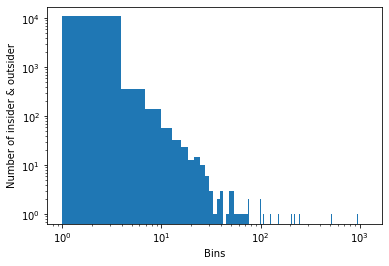

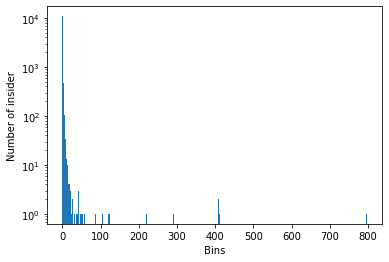

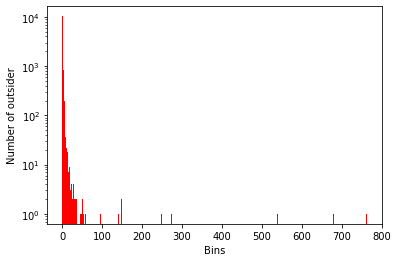

In [37]:
print("Number of pulled entities:", len(ents))
histo = []
histo_insider = []
histo_outsider = []
val_i = 0
val_o = 0

for k in ents:
    val_i = 0
    val_o = 0
    histo.append(len(ents[k]))
    for ent in ents[k]:
            if ent == "INSIDER":
                val_i += 1
            elif ent == "OUTSIDER":
                val_o += 1
    histo_insider.append(val_i)
    histo_outsider.append(val_o)

import matplotlib.pyplot as plt
plt.hist(histo, bins=400)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Bins")
plt.ylabel("Number of insider & outsider")
plt.show()

plt.hist(histo_insider, bins=400)
plt.yscale("log")
plt.xlabel("Bins")
plt.ylabel("Number of insider")
plt.show()

plt.hist(histo_outsider, bins=400, color='r')
plt.yscale("log")
plt.xlabel("Bins")
plt.ylabel("Number of outsider")
plt.show()

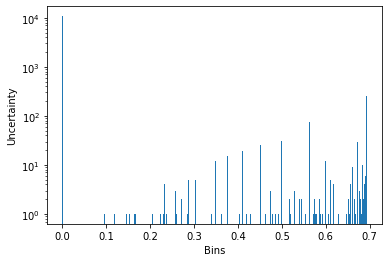

In [43]:
import math
ents_counts = {}
uncertainty = {}
for k in ents:
    values = ents[k]
    if k not in ents_counts:
        ents_counts[k] = (0.00001,0.00001)
    for v in values:
        if v == "INSIDER":
            ents_counts[k] = (ents_counts[k][0] + 1, ents_counts[k][1])
        elif v == "OUTSIDER":
            ents_counts[k] = (ents_counts[k][0], ents_counts[k][1] + 1)
    # compute binary cross entropy
    uncertainty[k] = -(ents_counts[k][0]/len(values))*math.log(ents_counts[k][0]/len(values)) - (ents_counts[k][1]/len(values))*math.log(ents_counts[k][1]/len(values))
plt.hist(uncertainty.values(), bins=400)    
plt.xlabel("Bins")
plt.ylabel("Uncertainty")
plt.yscale("log")
plt.show() 

In [55]:
i = 0
for k in uncertainty:
    if i < 50:
        if uncertainty[k] > 0.5:
            print(k, end=", ")
            print(ents_counts[k], end=", ")
    i += 1

what, (105.00001, 249.00001), it, (411.00001, 762.00001), god, (5.00001, 10.00001), vaccines, (87.00001, 273.00001), you, (409.00001, 539.00001), the past, (5.00001, 6.00001), the facts, (1.00001, 4.00001), who, (125.00001, 189.00001), a product, (2.00001, 3.00001), same thing, (1.00001, 1.00001), the govt, (1.00001, 2.00001), nothing, (19.00001, 47.00001), hcq, (3.00001, 4.00001), drs, (1.00001, 1.00001), 

In [57]:
i = 0
for k in uncertainty:
    if i < 500:
        if uncertainty[k] < 0.1 and len(ents[k]) > 3:
            print(k, end=", ")
            print(ents_counts[k], end=", ")
    i += 1

my family, (7.00001, 1e-05), governments, (1e-05, 11.00001), idk, (1e-05, 8.00001), me, (219.00001, 1e-05), good luck, (1e-05, 4.00001), a conspiracy theory, (1e-05, 5.00001), control, (1e-05, 12.00001), half, (1e-05, 5.00001), that point, (6.00001, 1e-05), the death, (1e-05, 8.00001), no problem, (1e-05, 5.00001), this sub, (1e-05, 21.00001), shit, (1e-05, 20.00001), months, (1e-05, 8.00001), op, (1e-05, 7.00001), the mainstream media, (1e-05, 6.00001), claims, (1e-05, 4.00001), the story, (1e-05, 7.00001), the bill, (1e-05, 6.00001), the government, (1e-05, 50.00001), more money, (1e-05, 8.00001), big pharma, (1e-05, 23.00001), pneumonia, (1e-05, 5.00001), covid, (3.00001, 149.00001), my point, (6.00001, 1e-05), the vaccines, (1e-05, 61.00001), access, (9.00001, 1e-05), this virus, (1e-05, 17.00001), the first time, (6.00001, 1e-05), china, (1e-05, 32.00001), deaths, (1e-05, 19.00001), corona virus, (1e-05, 4.00001), the virus, (2.00001, 96.00001), fauci, (1e-05, 10.00001), adverse r